# <center>Data</center>

К этому заданию прилагается база данных, находящаяся в файле `hw2.sqlite`, содержащая в себе следующие таблицы:

#### <center>zip_codes</center>

|    | zip      |     lat |      lng |
|---:|:---------|--------:|---------:|
|  0 | DC28210B | 39.9314 | -74.6831 |
|  1 | DC28210C | 40.7079 | -75.6816 |

#### <center>restaurant_types</center>

|    |   type_id | type   |
|---:|----------:|:-------|
|  0 |         0 | Bistro |
|  1 |         1 | Cafe   |

#### <center>restaurants</center>

|    |   id | zip      |   type |
|---:|-----:|:---------|-------:|
|  0 |    0 | D7D2DBAA |      4 |
|  1 |    1 | D7D2DBAB |      9 |

#### <center>tourists</center>

|    |   id | first_name   | last_name   |   age | zip      |
|---:|-----:|:-------------|:------------|------:|:---------|
|  0 |    0 | George       | Howard      |    26 | DC28210B |
|  1 |    1 | Adam         | Cox         |    72 | DC28210C |

---

### Задание 1: SQL (2 балла)

Напишите два запроса SQL, которые должны возвращать следующие таблицы (строки должны быть отсортированы по полю `id`):
   
#### <center>restaurants</center>

|    |   id | restaurant_type   |     lat |      lng |
|---:|-----:|:------------------|--------:|---------:|
|  0 |    0 | Tavern            | 38.9329 | -75.4142 |
|  1 |    1 | Chop House        | 38.8337 | -75.4187 |
  
#### <center>tourists</center>
  
|    |   id | first_name   | last_name   |   age |     lat |      lng |
|---:|-----:|:-------------|:------------|------:|--------:|---------:|
|  0 |    0 | George       | Howard      |    26 | 39.9314 | -74.6831 |
|  1 |    1 | Adam         | Cox         |    72 | 40.7079 | -75.6816 |

In [3]:
sql_restaurants = """
SELECT
    id,
    restaurant_types.type AS restaurants_type,
    lat,
    lng
FROM
    zip_codes
    INNER JOIN restaurants USING (zip)
    INNER JOIN restaurant_types ON restaurants.type = restaurant_types.type_id
ORDER BY
    id ASC
"""

In [4]:
sql_tourists = """
SELECT
    id,
    first_name,
    last_name,
    age,
    lat,
    lng
FROM
    zip_codes
    INNER JOIN tourists USING (zip)
ORDER BY
    id ASC
"""

Самый простой способ загрузить данные в датаферйм - это использовать *pd.read_sql*:

In [5]:
import sqlite3
import pandas as pd

In [6]:
# Создадим клиента для работы с Базой Данный SQLite:
con = sqlite3.Connection("data/hw2.sqlite")

# Загрузим данные из БД при помощи созданных запросов:
restaurants = pd.read_sql(sql=sql_restaurants, con=con)
tourists = pd.read_sql(sql=sql_tourists, con=con)

In [7]:
restaurants.head(3)

,id,restaurants_type,lat,lng
0,0,Tavern,38.932905,-75.414243
1,1,Chop House,38.833749,-75.418738
2,2,Oyster Bar,39.133371,-75.971980


In [8]:
tourists.head(2)

,id,first_name,last_name,age,lat,lng
0,0,George,Howard,26,39.931449,-74.683069
1,1,Adam,Cox,72,40.707946,-75.681644


---

# <center>KNN</center>

### Евклидово расстояние

**Евклидово расстояние** - это широко используемая метрика расстояния в машинном обучении и анализе данных, которая измеряет прямое расстояние между двумя точками в n-мерном пространстве. 

Формула для вычисления евклидова расстояния между двумя точками a и b в n-мерном пространстве выглядит следующим образом:

$$d(a,b) = \sqrt{\sum_{i=1}^{n}(a_i - b_i)^2}$$

где:  

- d(a,b) - евклидово расстояние между точками a и b
- a_i и b_i - i-я координата точек a и b соответственно
- n - количество измерений (или признаков) точек a и b.  
  
Другими словами, чтобы вычислить евклидово расстояние между двумя точками, мы сначала вычисляем разницу между каждой координатой двух точек, возводим каждую разницу в квадрат, суммируем квадраты разностей и берем квадратный корень из результата.

Для вычисления данной метрики мы будем использовать библиотеку **scipy**, а точнее, функцию **cdist**, входящую в модуль **spatial.distance**:

In [9]:
from scipy.spatial.distance import cdist

**cdist** прнимает на вход два массива `XA` и `XB`, а также опционально - параметр  `metric` (по умолчанию он равен *euclidean*, т.е. именно то, что нам и нужно).  
  
Главное требование к входящим массивам - у них должно быть равное количество столбцов.  
  
В качестве результата функция возвращает матрицу `AB`, где для каждой строки из массива `XA` возвращается расстояние до каждой строки из массива `XB`

### Задание 2: KNN (K Nearest Neighbours) (2 балла)

Напишите функцию, которая будет получать на вход координаты ресторанов `base`, координаты туристов `entities`, параметр `k` и должна будет возвращать для каждого туриста индексы `k` ближайших ресторанов:

In [10]:
import numpy as np


def knn(base: np.ndarray, entities: np.ndarray, k: int) -> np.ndarray:
    """
    Функция возвращает массив размером n*k,
    где n - переданное число наборов координат туристов
    k - переданное число ближайших ресторанов.
    Массив содержит индексы k ближайших ресторанов
    для каждого туриста в порядке увеличения расстояния
    """
    assert k <= len(base), "Число ресторанов не может быть меньше, чем к"

    result = []

    distance = cdist(entities.reshape(-1, 2), base.reshape(-1, 2), metric='euclidean')

    for d in distance:

        df = pd.DataFrame(data=d)

        result.append(df.sort_values(by=0).index[:k].to_numpy())
    
    return np.array(result)

In [11]:
base = restaurants.loc[:, ["lat", "lng"]].to_numpy()
entities = tourists.loc[0:2, ["lat", "lng"]].to_numpy()

In [12]:
knn(base, entities, 5)

array([[ 294,   79,  425,  345,  116],
       [1356, 1145, 1312, 1148, 1401],
       [1372, 1380, 1016, 1425, 1127]], dtype=int64)

Таким образом, индексы пяти ближайших ресторанов для первых трёх туристов должны быть:


|    0 |    1 |    2 |    3 |    4 |
|-----:|-----:|-----:|-----:|-----:|
|  294 |   79 |  425 |  345 |  116 |
| 1356 | 1145 | 1312 | 1148 | 1401 |
| 1372 | 1380 | 1016 | 1425 | 1127 |

---

# <center>KMeans</center>

Допустим, мы хотим открыть сеть из `K` отелей таким образом, чтобы каждый из них был окружён множеством ресторанов.  
  
Для этого мы решили поступить следующим образом:
1) мы произвольно выбираем на карте `K` точек (координат)
2) смотрим, к какой из выбранных точек ближе всего расположен каждый ресторан
3) группируем рестораны исходя из того, какая точка к ним ближе
4) "корректируем" точку в каждой группе таким образом, чтобы находилась в центре группы (вычисляем среднее значение каждой из координат)
5) повторяем шаги 2-4 до тех пор, пока наши группы не стабилизируются (т.е. до тех пор, пока назначения "ресторан"-"группа" не перестанут изменяться)

### Задание 3: KMeans (3 балла)

Напишите функцию для каждого из указанных выше шагов (шаг 3 и 4 можно объединить) (можно тажке оформить в виде класса):

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
class MyKmeans:
    """
    Класс реализует кластеризацию ресторанов, заданных координатами на k-групп методом KMeans.
    Под k-группами понимается желаемое число отелей, которые собираются построить.
    Атрибуты iteration и iteration_counter используются для хранения промежуточных
    вариантов расстановки отелей.
    """
    def __init__(self, restaurants, k=2):
        """
        При инициализции необходимо передать датафрейм с координатами ресторанов
        и желаемое число отелей
        """
        self.restaurants = restaurants
        self.restaurants_coord = self.restaurants[["lat", "lng"]].to_numpy()
        self.k = k

        assert len(self.restaurants) > 1, \
            "Список ресторанов должен состоять хотя бы из двух"

        assert self.k <= len(self.restaurants), \
            "Число предполагаемых отелей не должно превосходить число ресторанов"

        self.iteration = {}
        self.iteration_counter = 0
        self.__get_random_centroids()
        return
    
    def __get_random_centroids(self):
        """
        Служебный метод. Случайным образом инициализирует стартовые значения отелей
        """
        # self.hotels = np.hstack((np.random.uniform(self.restaurants["lat"].min(),
        #                                            self.restaurants["lat"].max(),
        #                                            (self.k, 1)), 
        #                          np.random.uniform(self.restaurants["lng"].min(),
        #                                            self.restaurants["lng"].max(),
        #                                            (self.k, 1)))) \
        #                             .reshape(1, self.k, 2)
        self.hotels = self.restaurants[["lat", "lng"]].sample(n=self.k).to_numpy()
        return

    def __find_closest_centroids(self):
        """
        Служебный метод. Определяет ближайший отель к каждому ресторану
        и вносит информацию о текущем ближайшем отеле в датафрейм ресторанов.
        """
        result = []

        distance = cdist(self.restaurants_coord.reshape(-1, 2),
                         self.hotels.reshape(-1, 2),
                         metric='euclidean')
        
        for d in distance:

            df = pd.DataFrame(data=d)

            result.append(df.sort_values(by=0).index[:1][0])

        self.restaurants["hotel_id"] = pd.Series(result)
        return
    
    def __update_centroids(self) -> None:
        """
        Служебный метод. Пересчитывает новые координаты для каждого отеля.
        """
        self.hotels = self.restaurants.groupby("hotel_id") \
                          .aggregate({"lat": "mean", "lng": "mean"}) \
                          .to_numpy()
        return

    def find_optimize_coords(self):
        """
        Вызываемый метод. Оптимизирует размещение заданного числа отелей относительно ресторанов.
        Последовательно вызывает методы __find_closest_centroids и __update_centroids до тех пор,
        пока на двух соседних итерациях вектора классов не совпадут. 
        """

        prev_grups = np.zeros(len((self.restaurants)))

        self.__find_closest_centroids()

        cur_grups = self.restaurants["hotel_id"].to_numpy()

        self.iteration[self.iteration_counter] = (self.restaurants.copy(),
                                                  self.hotels)

        while (prev_grups != cur_grups).any():
            self.iteration_counter += 1
            prev_grups = self.restaurants["hotel_id"].to_numpy()
            self.__update_centroids()
            self.__find_closest_centroids()
            cur_grups = self.restaurants["hotel_id"].to_numpy()
            self.iteration[self.iteration_counter] = (self.restaurants.copy(),
                                                  self.hotels)
        return
    
    def show_iteration(self, last=False):
        """
        Вызываемый метод. Используется для отображения результатов графически.
        параметр last=True позволяет вывести только последнее изображение.
        """
        my_palette = sns.color_palette("husl", 50)
        if last:
            iteration_counter = len(self.iteration) - 1
            df_rest = self.iteration[iteration_counter][0]
            df_hotels = pd.DataFrame(data = self.iteration[iteration_counter][1] \
                                    .reshape(self.k, 2))

            g = sns.scatterplot(data=df_rest, x="lng", y="lat", hue="hotel_id", palette=my_palette)
            g = sns.scatterplot(data=df_hotels, x=1, y=0, s=100, color=".2", marker="+")
            plt.show()
        else:
            for iteration_counter in range(len(self.iteration)):
                df_rest = self.iteration[iteration_counter][0]
                df_hotels = pd.DataFrame(data = self.iteration[iteration_counter][1] \
                                        .reshape(self.k, 2))

                g = sns.scatterplot(data=df_rest, x="lng", y="lat", hue="hotel_id", palette=my_palette)
                g = sns.scatterplot(data=df_hotels, x=1, y=0, s=100, color=".3", marker="+")
                plt.show()
        return


In [15]:
obj = MyKmeans(restaurants, 6)

In [16]:
obj.find_optimize_coords()

C:\Users\Николай\AppData\Local\Temp\ipykernel_7952\2761302518.py:109: UserWarning: The palette list has more values (50) than needed (6), which may not be intended.
  g = sns.scatterplot(data=df_rest, x="lng", y="lat", hue="hotel_id", palette=my_palette)


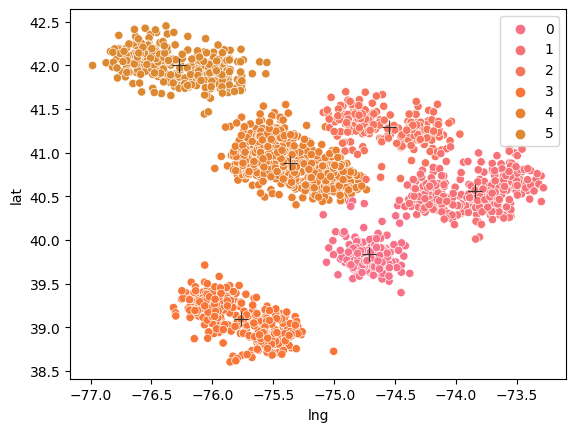

In [17]:
obj.show_iteration(last=True)

---

# <center>DBScan (3 балла)</center>

Мы хотим объединить наши рестораны в компактные группы, которые можно было бы относительно быстро посетить.
  
Для этого мы устанавливаем пороговое расстояние между ресторанами одной группы - `e`.  
  
Также мы не хотим, чтобы у нас получились группы из пары-тройки ресторанов, поэтому мы задаём второй параметр: `N`

Наш алгоритм будет выглядеть следующим образом:
1) рассчитываем расстояния между точками
2) выбираем случайным образом точку
3) смотрим, сколько других точек есть на расстоянии не более `e` от него (формируем группу)
4) также проверяем других членов этой группы, есть ли такие из них, которые находятся рядом с точками, не вошедшими в группу (если да - то включаем эти точки)
5) повторяем шаг 4 до тех пор, пока мы не сформируем группу, на расстоянии `e` от границ которой нет других точек
6) повторяем шаги 1-5 до тех пор, пока не останется неисследованных точек
7) те группы, в которых меньше `N` элементов, мы помечаем как *outliers*

### Задание 4: DBScan

Создайте объекты, в которых будут храниться:
- список уже изученных точек
- имеющиеся группы и точки, которые в них входят
  
Заранее продумайте, какой тип данных лучше всего подходит для этих задач

In [18]:
visited = set()
groups  = {}
# но этим я не воспользуюсь...

In [19]:
if "hotel_id" in restaurants.columns:
    restaurants.drop("hotel_id", axis=1, inplace=True)

In [20]:
class MyBDScan:
    """
    Класс реализует кластеризацию ресторанов, заданных координатами, методом BDScan.
    """
    def __init__(self, restaurants, e=0.1, N=5):
        """
        Классу нужно передать датафрейм ресторанов, максимально допустимое расстояние между
        точками и минимальное число соседей для объединения в кластер.
        В датафрейм с координатами добавим колонку "claster" в которой могут быть следующие значения:
        - nan - точка еще ни разу не рассматривалась
        - 0 - точка рассматривалась. Пока отшельник (или вовсе шум)
        - int > 0 - принадлежит указанной группе.

        Вдохновлялся https://habr.com/ru/post/322034/
        """
        self.restaurants = restaurants
        self.e = e
        self.N = N
        self.restaurants_coord = self.restaurants[["lat", "lng"]].to_numpy()

        assert len(self.restaurants) > 1, \
            "Список ресторанов должен состоять хотя бы из двух"
        
        self.restaurants["claster"] = np.nan
        self.claster_counter = 0
        self.__distances()
    
    def __distances(self):
        """
        Служебный метод. Рассчитывает матрицу расстояний "каждый до каждого"
        и переводит ее в датафрейм
        """
        self.dist_between_points = pd.DataFrame(data = cdist(self.restaurants_coord,
                               self.restaurants_coord))
        return
    
    def __get_random_point(self):
        """
        Служебный метод. Выбирает произвольную точку из перечня непосещенных точек.
        """
        self.cur_index = self.restaurants.query("claster.isnull()").sample(1).index[0]
        return

    def __region_query(self):
        """
        Служебный метод. Находит индексы всех соседей, находящихся "близко" от текущей точки.
        """
        return list(self.dist_between_points \
                    [self.dist_between_points.loc[self.cur_index] <= self.e].index)

    def making_clusters(self):
        """
        Вызываемый метод. Выполняет кластеризацию по методу DBScan.
        """
        while self.restaurants["claster"].isnull().any():
            self.claster_counter += 1
            self.__get_random_point()
            self.neighbours = self.__region_query()
            if len(self.neighbours) < self.N:
                self.restaurants.loc[self.cur_index, "claster"] = 0
                self.neighbours = []
            else:
                self.restaurants.loc[self.cur_index, "claster"] = self.claster_counter
                while self.neighbours:
                    self.cur_index = self.neighbours.pop()
                    if self.restaurants.loc[self.cur_index, "claster"] == 0 \
                            or pd.isna(self.restaurants.loc[self.cur_index, "claster"]):
                        self.restaurants.loc[self.cur_index, "claster"] = self.claster_counter
                        second_neighbours = self.__region_query()
                        if len(second_neighbours) >= self.N:
                            self.neighbours.extend(second_neighbours)

        # не знаю почему, но к концу работы метода всё же образуются группы
        # с числом точек меньше допустимого, пока сделаем такой трюк:
        counts = self.restaurants["claster"].value_counts()
        to_replace = counts[counts < self.N].index
        self.restaurants["claster"].replace(to_replace, 0, inplace=True)
        return

    def show_clasters(self):
        """
        Вызываемый метод. Используется для отображения результатов графически.
        """
        my_palette = sns.color_palette("husl", 50)
        sns.scatterplot(data=self.restaurants, x="lng", y="lat", hue="claster", palette=my_palette)
        return


In [21]:
obj = MyBDScan(restaurants, 0.1, 5)

In [22]:
obj.making_clusters()

C:\Users\Николай\AppData\Local\Temp\ipykernel_7952\1430865667.py:85: UserWarning: The palette list has more values (50) than needed (6), which may not be intended.
  sns.scatterplot(data=self.restaurants, x="lng", y="lat", hue="claster", palette=my_palette)


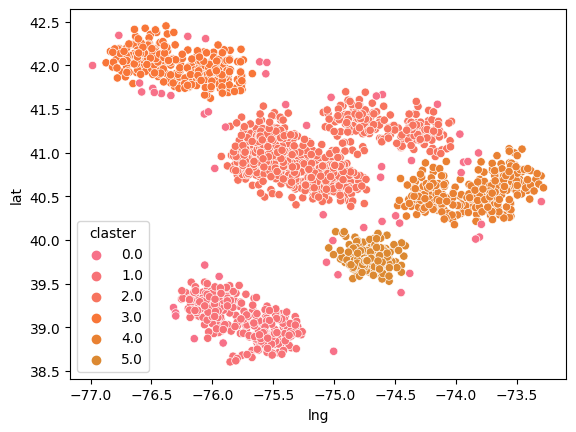

In [23]:
obj.show_clasters();

---

# <center>Бонус (2 балла)</center>

Как уже было сказано, для вычисления расстояния существует функция **cdist**.  
  
#### Задание:
Напишите свою функцию с использованием **numpy**, которая будет принимать на вход два массива `XA` и `XB` (как и **cdist**) и возвращать матрицу евклидовых расстояний между соответствующими элементами:

In [24]:
XA = base
XB = entities

In [25]:
def euclidean_distance(XA: np.ndarray, XB: np.ndarray) -> np.ndarray:
    """
    Функция рассчитывает евклидово расстояние между
    двумя векторами точек, заданных в виде массива координат.
    Ссылка на стаковерфлов:D
    https://stackoverflow.com/questions/6430091/efficient-distance-calculation-between-n-points-and-a-reference-in-numpy-scipy
    """
    return np.sqrt(np.sum((XA[:, None] - XB)**2, axis=2))

In [26]:
my_dist = euclidean_distance(XA, XB)
scipy_dist = cdist(XA, XB)

In [27]:
(my_dist == scipy_dist).all()

True

Таким образом, обе функции должны дать одинаковый результат:

```python
euclidean_distance(XA, XB) == cdist(XA, XB, metric='euclidean')
```

Попробуйте реализовать решение в одну строку)

---

# <center>Удачи!</center>